In [1]:
import numpy as np
import os
import pandas as pd
from scipy.stats import linregress
from sklearn.decomposition import PCA


In [2]:
class UnsupervisedEmbeddingQualityEvaluation:

    @staticmethod
    def RankMe(M, epsilon=1e-7):
        U, Sigma, Vt = np.linalg.svd(M, full_matrices=False)
        pk = Sigma / (np.sum(Sigma) + epsilon)
        min_dim = min(M.shape)
        entropy_value = -np.sum(pk[:min_dim] * np.log(pk[:min_dim] + epsilon))
        return np.exp(entropy_value)

    @staticmethod
    def NESum(M):
        C = np.cov(M, rowvar=False)
        Lambda, _ = np.linalg.eig(C)
        Lambda = np.sort(Lambda)[::-1]
        n = len(Lambda)
        if Lambda[0] == 0:
            return 0
        return np.sum([Lambda[i] / Lambda[0] for i in range(n)])

    @staticmethod
    def Stable_rank(M):
        fro_norm = np.linalg.norm(M, 'fro')
        two_norm = np.linalg.norm(M, 2)
        return (fro_norm ** 2) / (two_norm ** 2)

    @staticmethod
    def PCA_top2_variance(M):
        pca = PCA(n_components=2)
        pca.fit(M)
        return pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]

In [3]:
# Define the path to the folders
base_path = '/.../.../.../.../Unsupervised_Evaluation_LLM/PaperWork'
folders = ['DNA_BERT2', 'HyenaDNA', 'mistral','nucleotide-transformer-500m-human-ref','genalm','grover']

In [4]:
# Dictionary to store matrices
matrices = {}

# Read and store matrices
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            emb_file = np.load(file_path, allow_pickle=True)
            
            # Convert to array directly
            if folder == 'nucleotide-transformer-500m-human-ref':
                matrices[file_name] = np.asarray(emb_file)
            else:
                matrices[file_name] = np.vstack(np.asarray(emb_file))


In [5]:
import time
import numpy as np
import pandas as pd

# === Define datasets, model mapping, and evaluator ===
datasets = [
    "demo_coding_vs_intergenomic_seqs",
    "human_enhancers_cohn",
    "human_nontata_promoters",
    "human_enhancers_ensembl"
]

model_paths_and_suffixes = {
    'DNA_BERT2':                         'DB2_Embeddings',
    'HyenaDNA':                          'HD_Embeddings',
    'mistral':                           'mistral_Embeddings',
    'nucleotide-transformer-500m-human-ref': 'NT_Embeddings',
    'genalm':                            'GENALM_Embeddings',
    'grover':                            'GROVER_Embeddings'
}

evaluator = UnsupervisedEmbeddingQualityEvaluation()
results = []

# === Combine train & test and compute metrics with separate timings ===
for dataset in datasets:
    for model_folder, suffix in model_paths_and_suffixes.items():
        train_key = f"train_{dataset}_{suffix}.npy"
        test_key = f"test_{dataset}_{suffix}.npy"

        if train_key in matrices and test_key in matrices:
            print(f"Processing Dataset: {dataset} | Model: {model_folder}")
            train_emb = matrices[train_key]
            test_emb = matrices[test_key]

            try:
                combined_emb = np.vstack([train_emb, test_emb])
            except Exception as e:
                print(f"Error combining {train_key} and {test_key}: {e}")
                continue

            # Compute each metric with individual timing
            try:
                start = time.time()
                rankme = evaluator.RankMe(combined_emb)
                time_rankme = time.time() - start

                start = time.time()
                nesum = evaluator.NESum(combined_emb)
                time_nesum = time.time() - start

                start = time.time()
                stable_rank = evaluator.Stable_rank(combined_emb)
                time_stable_rank = time.time() - start

                start = time.time()
                pca1, pca2 = evaluator.PCA_top2_variance(combined_emb)
                time_pca = time.time() - start

                results.append({
                    "Dataset": dataset,
                    "Model": model_folder,
                    "RankMe": rankme,
                    "RankMe_Time_sec": time_rankme,
                    "NESum": nesum,
                    "NESum_Time_sec": time_nesum,
                    "StableRank": stable_rank,
                    "StableRank_Time_sec": time_stable_rank,
                    "PCA_Var_1": pca1,
                    "PCA_Var_2": pca2,
                    "PCA_Time_sec": time_pca
                })
            except Exception as e:
                print(f"Error computing metrics for {dataset} - {model_folder}: {e}")

# === Save and Display Results ===
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Dataset", "Model"])

Processing Dataset: demo_coding_vs_intergenomic_seqs | Model: DNA_BERT2
Processing Dataset: demo_coding_vs_intergenomic_seqs | Model: HyenaDNA
Processing Dataset: demo_coding_vs_intergenomic_seqs | Model: mistral
Processing Dataset: demo_coding_vs_intergenomic_seqs | Model: nucleotide-transformer-500m-human-ref
Processing Dataset: demo_coding_vs_intergenomic_seqs | Model: genalm
Processing Dataset: demo_coding_vs_intergenomic_seqs | Model: grover
Processing Dataset: human_enhancers_cohn | Model: DNA_BERT2
Processing Dataset: human_enhancers_cohn | Model: HyenaDNA
Processing Dataset: human_enhancers_cohn | Model: mistral
Processing Dataset: human_enhancers_cohn | Model: nucleotide-transformer-500m-human-ref
Processing Dataset: human_enhancers_cohn | Model: genalm
Processing Dataset: human_enhancers_cohn | Model: grover
Processing Dataset: human_nontata_promoters | Model: DNA_BERT2
Processing Dataset: human_nontata_promoters | Model: HyenaDNA
Processing Dataset: human_nontata_promoters |

In [8]:
results_df

,Dataset,Model,RankMe,RankMe_Time_sec,NESum,NESum_Time_sec,StableRank,StableRank_Time_sec,PCA_Var_1,PCA_Var_2,PCA_Time_sec
0,demo_coding_vs_intergenomic_seqs,DNA_BERT2,419.495148,11.303878,3.668379,1.489985,1.271610,5.313015,0.272606,0.102624,1.363556
1,demo_coding_vs_intergenomic_seqs,HyenaDNA,19.328695,3.167159,2.179398,0.286461,1.016496,1.593343,0.458850,0.127657,0.441689
4,demo_coding_vs_intergenomic_seqs,genalm,608.974609,16.577255,4.652702,2.554790,1.539069,7.736907,0.214933,0.138904,1.747542
5,demo_coding_vs_intergenomic_seqs,grover,368.302460,11.300352,4.937262,1.469066,1.584341,5.338414,0.202545,0.129690,1.554201
2,demo_coding_vs_intergenomic_seqs,mistral,90.246552,3.114266,2.739331,0.281892,1.102305,1.532362,0.365060,0.219968,0.393791
3,demo_coding_vs_intergenomic_seqs,nucleotide-transformer-500m-human-ref,527.946805,22.068240,5.358238,3.655076,1.106825,10.553082,0.186629,0.080154,4.732298
6,human_enhancers_cohn,DNA_BERT2,318.857513,3.562870,1.644616,1.113350,1.213508,1.428156,0.608046,0.072163,0.359804
7,human_enhancers_cohn,HyenaDNA,16.580971,0.722755,2.663557,0.100110,1.013167,0.345540,0.375439,0.240379,0.088756
10,human_enhancers_cohn,genalm,562.068909,4.703441,3.661077,1.440871,1.327365,2.163233,0.273144,0.103991,0.510444
11,human_enhancers_cohn,grover,298.741516,3.142292,4.597033,0.757966,1.322155,1.453815,0.217532,0.199210,0.381413


In [9]:
# Compute average time per metric per model
summary = results_df.groupby('Model')[['RankMe_Time_sec', 'NESum_Time_sec', 'StableRank_Time_sec', 'PCA_Time_sec']].mean().reset_index()

In [10]:
summary

,Model,RankMe_Time_sec,NESum_Time_sec,StableRank_Time_sec,PCA_Time_sec
0,DNA_BERT2,9.174289,1.379359,4.302275,1.096204
1,HyenaDNA,2.500772,0.235659,1.231265,0.345096
2,genalm,13.368029,2.240141,6.260995,1.432887
3,grover,9.050964,1.316509,4.275610,1.143789
4,mistral,2.465883,0.238541,1.220499,0.319933
5,nucleotide-transformer-500m-human-ref,17.932514,3.237071,8.475091,3.761698




## Senstivity to Sequence Length Analysis

In [27]:
# Load sequences (adjust paths as needed)
train_csv = pd.read_csv(f"{base_path}/datasets/train_human_enhancers_ensembl.csv")
test_csv = pd.read_csv(f"{base_path}/datasets/test_human_enhancers_ensembl.csv")
full_df = pd.concat([train_csv, test_csv], ignore_index=True)

# Compute sequence lengths
full_df['seq_length'] = full_df['seq'].str.len()

In [28]:
full_df

,seq,label,seq_length
0,TGTTGTTGTTGTTGTTGTTGTTGTTGGTTTTGACACAGTAATGGGA...,0,166
1,CATATATTTTACTGATAAGTCATGCAGGTTTATCTAAACTTACAGG...,0,199
2,ATGCAGCTACACAGCCCTTAAATAAAAATGTTTAGCACTGAATATC...,0,150
3,AAATGACAGGTTGATGGGTGCAGCAAACCACCATGGCATGTGTATA...,0,394
4,TCTTACTATAGTACAGTACCAAAACCATGAACAGAACATTGGTACA...,0,389
...,...,...,...
154837,GCATTCCTCGGCTGGTGGCACAGTGGAGTATTGGAGAATGAGGGTT...,1,227
154838,CTGTCGGGAGATGGAGAAGGGCAGCCTTAAGACCCTGTTGAGGAGG...,1,183
154839,TAAAAAAAAAAAAAAAAAAAAAAGTGAACTCTGTTCCTTCGGGAAG...,1,157
154840,TGTAAAAAAAAAAA,1,14


In [34]:
# Create 6 bins with equal number of samples based on quantiles
full_df['length_bin'] = pd.qcut(full_df['seq_length'], q=6, duplicates='drop')

# Create dictionary mapping bin label to sequence indices
bin_indices = {
    bin_label: full_df.index[full_df['length_bin'] == bin_label].tolist()
    for bin_label in full_df['length_bin'].cat.categories
}


In [35]:
# Count number of samples in each bin
bin_counts = full_df['length_bin'].value_counts().sort_index()
print("Number of sequences in each length bin:")
print(bin_counts)

Number of sequences in each length bin:
(1.999, 144.0]    26210
(144.0, 207.0]    25426
(207.0, 269.0]    26066
(269.0, 331.0]    25920
(331.0, 390.0]    25618
(390.0, 573.0]    25602
Name: length_bin, dtype: int64


In [36]:
evaluator = UnsupervisedEmbeddingQualityEvaluation()

# === Model mapping and evaluator ===
model_paths_and_suffixes = {
    'DNA_BERT2':                         'DB2_Embeddings',
    'HyenaDNA':                          'HD_Embeddings',
    'mistral':                           'mistral_Embeddings',
    'nucleotide-transformer-500m-human-ref': 'NT_Embeddings',
    'genalm':                            'GENALM_Embeddings',
    'grover':                            'GROVER_Embeddings'
}

results = []

# === Evaluate per bin per model ===
dataset = "human_enhancers_ensembl"
for model_folder, suffix in model_paths_and_suffixes.items():
    train_key = f"train_{dataset}_{suffix}.npy"
    test_key = f"test_{dataset}_{suffix}.npy"

    if train_key in matrices and test_key in matrices:
        print(f"Processing Model: {model_folder}")
        train_emb = matrices[train_key]
        test_emb = matrices[test_key]
        full_emb = np.vstack([train_emb, test_emb])

        for bin_label, indices in bin_indices.items():
            if len(indices) == 0:
                continue

            try:
                emb_subset = full_emb[indices]
                rankme = evaluator.RankMe(emb_subset)
                nesum = evaluator.NESum(emb_subset)
                stable_rank = evaluator.Stable_rank(emb_subset)

                results.append({
                    "Dataset": dataset,
                    "Model": model_folder,
                    "LengthBin": str(bin_label),
                    "NumSeqs": len(indices),
                    "RankMe": rankme,
                    "NESum": nesum,
                    "StableRank": stable_rank,
                    
                })

            except Exception as e:
                print(f"Error computing bin metrics for {model_folder} | Bin {bin_label}: {e}")
    else:
        print(f"Missing embeddings for model: {model_folder}")

# === Save and display results ===
senstivity_results_df = pd.DataFrame(results)

Processing Model: DNA_BERT2
Processing Model: HyenaDNA
Processing Model: mistral
Processing Model: nucleotide-transformer-500m-human-ref
Processing Model: genalm
Processing Model: grover


In [38]:
senstivity_results_df

,Dataset,Model,LengthBin,NumSeqs,RankMe,NESum,StableRank
0,human_enhancers_ensembl,DNA_BERT2,"(1.999, 144.0]",26210,431.251495,2.071036,2.174540
1,human_enhancers_ensembl,DNA_BERT2,"(144.0, 207.0]",25426,431.225555,4.748893,1.261451
2,human_enhancers_ensembl,DNA_BERT2,"(207.0, 269.0]",26066,407.278259,3.281441,1.233042
3,human_enhancers_ensembl,DNA_BERT2,"(269.0, 331.0]",25920,385.144653,2.548390,1.229757
4,human_enhancers_ensembl,DNA_BERT2,"(331.0, 390.0]",25618,365.838715,2.127855,1.227370
5,human_enhancers_ensembl,DNA_BERT2,"(390.0, 573.0]",25602,336.630676,1.817903,1.230428
6,human_enhancers_ensembl,HyenaDNA,"(1.999, 144.0]",26210,20.723392,2.874140,1.024731
7,human_enhancers_ensembl,HyenaDNA,"(144.0, 207.0]",25426,18.994192,3.183060,1.013761
8,human_enhancers_ensembl,HyenaDNA,"(207.0, 269.0]",26066,18.960321,3.117032,1.013021
9,human_enhancers_ensembl,HyenaDNA,"(269.0, 331.0]",25920,19.042393,3.212468,1.013597


In [1]:
# from scipy.stats import friedmanchisquare

# metrics = ['RankMe', 'NESum', 'StableRank']


# # === Model-wise Friedman Test (per model across bins) ===
# print("\n\n=== Friedman Test: Within Each Model Across Length Bins ===")
# for metric in metrics:
#     print(f"\nMetric: {metric}")
#     for model in senstivity_results_df['Model'].unique():
#         df_model = senstivity_results_df[senstivity_results_df['Model'] == model]
#         df_model_sorted = df_model.sort_values("LengthBin")
#         values = df_model_sorted[metric].values

#         if len(values) >= 3:
#             # Each bin is treated as a block, so transpose the 1D array into groups
#             try:
#                 stat, p = friedmanchisquare(*[[v] for v in values])
#                 print(f"{model:45s} | Friedman chi-square = {stat:.3f}, p = {p:.4f}")
#             except Exception as e:
#                 print(f"{model:45s} | Error: {e}")
#         else:
#             print(f"{model:45s} | Not enough bins for test")


In [37]:
unsup = pd.read_csv('/.../.../.../.../Unsupervised_Evaluation_LLM/PaperWork/Result2_R1/embedding_quality_evaluation.csv')
dim_pcs = pd.read_csv('/.../.../.../.../Unsupervised_Evaluation_LLM/PaperWork/Result1_R1_AllModels/effective_dimension_results.csv')

In [49]:
dim_pcs

,Model,Dataset,Effective_Dim_k,Embedding_Dim,Ratio,Dataset_clean
0,DNA_BERT2,train_demo_coding_vs_intergenomic_seqs_DB2_Emb...,385,768,0.5013,demo_coding_vs_intergenomic_seqs
1,DNA_BERT2,train_human_enhancers_cohn_DB2_Embeddings,247,768,0.3216,human_enhancers_cohn
2,DNA_BERT2,train_human_enhancers_ensembl_DB2_Embeddings,335,768,0.4362,human_enhancers_ensembl
3,DNA_BERT2,train_human_ensembl_regulatory_DB2_Embeddings,309,768,0.4023,human_ensembl_regulatory
4,DNA_BERT2,train_human_nontata_promoters_DB2_Embeddings,347,768,0.4518,human_nontata_promoters
5,DNA_BERT2,train_human_ocr_ensembl_DB2_Embeddings,340,768,0.4427,human_ocr_ensembl
6,HyenaDNA,train_demo_coding_vs_intergenomic_seqs_HD_Embe...,42,256,0.1641,demo_coding_vs_intergenomic_seqs
7,HyenaDNA,train_human_enhancers_cohn_HD_Embeddings,36,256,0.1406,human_enhancers_cohn
8,HyenaDNA,train_human_enhancers_ensembl_HD_Embeddings,29,256,0.1133,human_enhancers_ensembl
9,HyenaDNA,train_human_ensembl_regulatory_HD_Embeddings,27,256,0.1055,human_ensembl_regulatory


In [43]:
unsup

,Dataset,Model,RankMe,NESum,StableRank,PCA_Var_1,PCA_Var_2
0,demo_coding_vs_intergenomic_seqs,DNA_BERT2,419.495148,3.668379,1.271610,0.272606,0.102624
1,demo_coding_vs_intergenomic_seqs,HyenaDNA,19.328695,2.179398,1.016496,0.458850,0.127657
2,demo_coding_vs_intergenomic_seqs,genalm,608.974609,4.652702,1.539069,0.214933,0.138904
3,demo_coding_vs_intergenomic_seqs,grover,368.302460,4.937262,1.584341,0.202545,0.129690
4,demo_coding_vs_intergenomic_seqs,mistral,90.246552,2.739331,1.102305,0.365060,0.219968
5,demo_coding_vs_intergenomic_seqs,nucleotide-transformer-500m-human-ref,527.946805,5.358238,1.106825,0.186629,0.080154
6,human_enhancers_cohn,DNA_BERT2,318.857513,1.644616,1.213508,0.608046,0.072163
7,human_enhancers_cohn,HyenaDNA,16.580971,2.663557,1.013167,0.375439,0.240379
8,human_enhancers_cohn,genalm,562.068909,3.661077,1.327365,0.273145,0.103991
9,human_enhancers_cohn,grover,298.741516,4.597033,1.322155,0.217532,0.199210


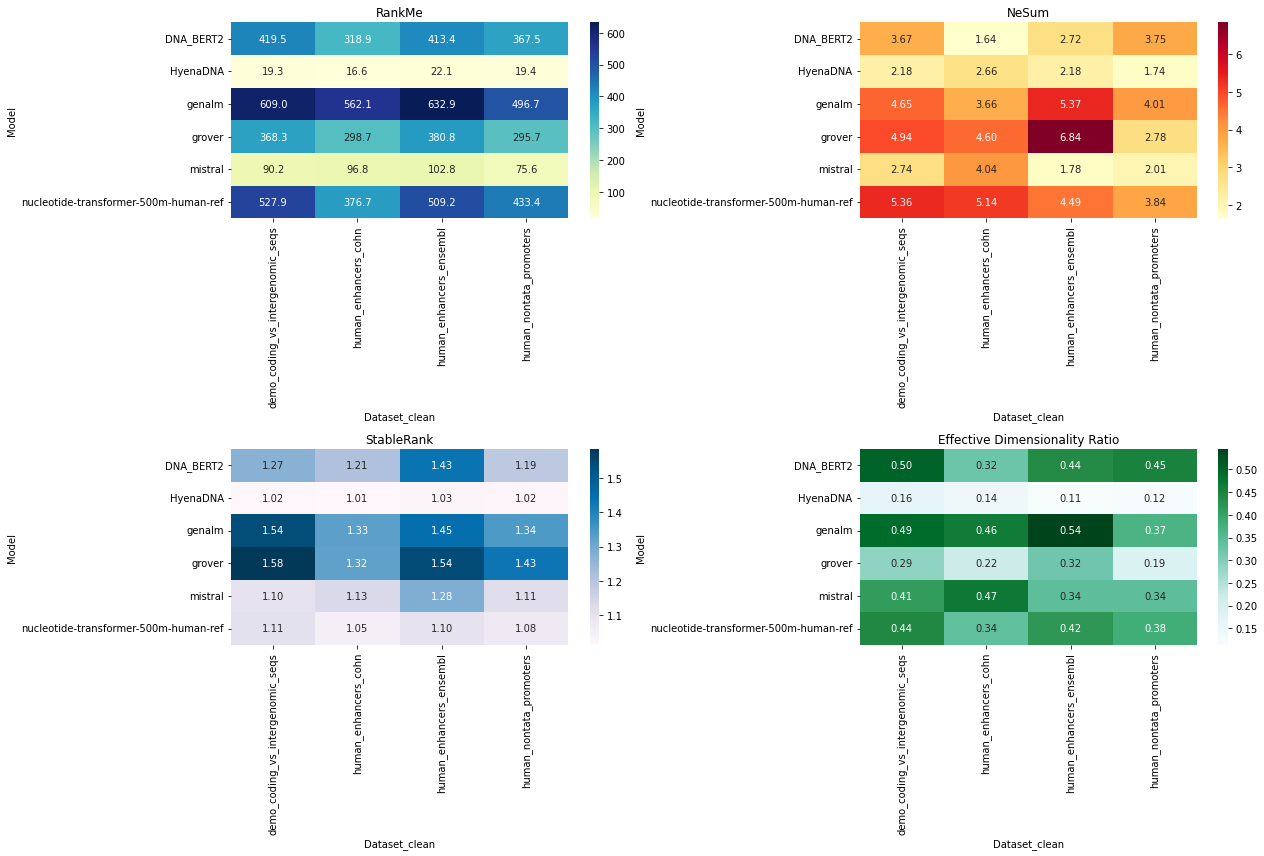


Pearson Correlations with Effective Dimensionality Ratio:
RankMe: 0.694
NESum: 0.438
StableRank: 0.335


In [53]:
%matplotlib inline

# Define datasets of interest
target_datasets = {
    "demo_coding_vs_intergenomic_seqs",
    "human_enhancers_cohn",
    "human_enhancers_ensembl",
    "human_nontata_promoters"
}

# Extract clean dataset names from filenames
def extract_dataset_name(path):
    match = re.match(r"(?:train|test)_([a-zA-Z0-9_]+?)_[^_]+_Embeddings", path)
    return match.group(1) if match else path

dim_pcs["Dataset_clean"] = dim_pcs["Dataset"].apply(extract_dataset_name)

# Filter only exact datasets
dim_pcs = dim_pcs[dim_pcs["Dataset_clean"].isin(target_datasets)]
unsup = unsup[unsup["Dataset"].isin(target_datasets)]

# Merge on Model and cleaned Dataset
merged_df = pd.merge(dim_pcs, unsup, left_on=["Model", "Dataset_clean"], right_on=["Model", "Dataset"])

# Prepare data for heatmap
heatmap_data = merged_df[["Model", "Dataset_clean", "RankMe", "NESum", "StableRank", "Ratio"]]

# Pivot tables
pivot_rankme = heatmap_data.pivot(index="Model", columns="Dataset_clean", values="RankMe")
pivot_nesum = heatmap_data.pivot(index="Model", columns="Dataset_clean", values="NESum")
pivot_stablerank = heatmap_data.pivot(index="Model", columns="Dataset_clean", values="StableRank")
pivot_ratio = heatmap_data.pivot(index="Model", columns="Dataset_clean", values="Ratio")

# Plot heatmaps
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sns.heatmap(pivot_rankme, annot=True, fmt=".1f", cmap="YlGnBu", ax=axes[0, 0])
axes[0, 0].set_title("RankMe")

sns.heatmap(pivot_nesum, annot=True, fmt=".2f", cmap="YlOrRd", ax=axes[0, 1])
axes[0, 1].set_title("NeSum")

sns.heatmap(pivot_stablerank, annot=True, fmt=".2f", cmap="PuBu", ax=axes[1, 0])
axes[1, 0].set_title("StableRank")

sns.heatmap(pivot_ratio, annot=True, fmt=".2f", cmap="BuGn", ax=axes[1, 1])
axes[1, 1].set_title("Effective Dimensionality Ratio")

plt.tight_layout()
plt.show()


In [54]:
# === Correlation analysis ===
metrics = ["RankMe", "NESum", "StableRank"]
correlations = {metric: merged_df["Ratio"].corr(merged_df[metric]) for metric in metrics}

print("\nPearson Correlations with Effective Dimensionality Ratio:")
for metric, corr_val in correlations.items():
    print(f"{metric}: {corr_val:.3f}")


Pearson Correlations with Effective Dimensionality Ratio:
RankMe: 0.694
NESum: 0.438
StableRank: 0.335
